In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import masks
import lensing_qso_cross

In [2]:
NSIDE = 2048
G_max = 20

In [3]:
fn_Cls = f'../data/Cls/Cls_G{G_max}_NSIDE{NSIDE}.npy'

In [4]:
fn_gaia = f'../data/gaia_G{G_max}.fits'
fn_rand = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
mask_names_gaia = ['mcs', 'dust']
Av_max = 0.2

In [5]:
mask_lensing = lensing_qso_cross.get_planck_lensing_mask(NSIDE)

Getting Planck lensing mask


In [6]:
map_lensing = lensing_qso_cross.get_planck_lensing_map(NSIDE)

Getting Planck lensing map


In [7]:
mask_overdensity = masks.get_qso_mask(NSIDE, mask_names_gaia, Av_max=Av_max)

Getting QSO mask
2048 3.1 ../data/maps/map_dust_NSIDE2048.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE2048.npy


In [8]:
map_overdensity = lensing_qso_cross.get_qso_overdensity_map(NSIDE, fn_gaia, fn_rand, mask_overdensity)

Getting QSO overdensity map
Applied mask, kept 0.709 of sources
Applied mask, kept 0.699 of sources


/home/ksf293/gaia-quasars-lss/notebooks/../code/lensing_qso_cross.py:94: RuntimeWarning: divide by zero encountered in true_divide
  map_ratio = map_nqso_gaia / map_nqso_rand
/home/ksf293/gaia-quasars-lss/notebooks/../code/lensing_qso_cross.py:94: RuntimeWarning: invalid value encountered in true_divide
  map_ratio = map_nqso_gaia / map_nqso_rand


## Plot maps & masks

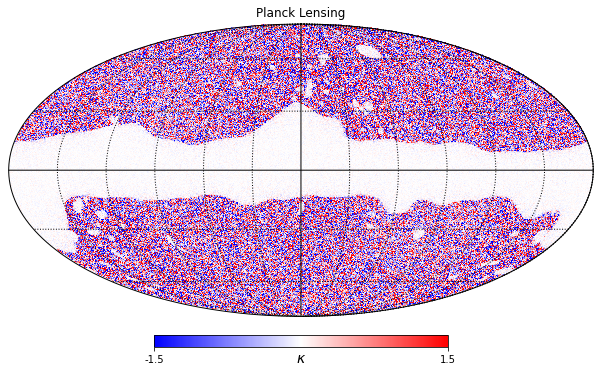

In [9]:
hp.mollview(map_lensing, title=rf"Planck Lensing", unit=r"$\kappa$",
            cmap='bwr', min=-1.5, max=1.5, #coord=['C', 'G']
)
hp.graticule()

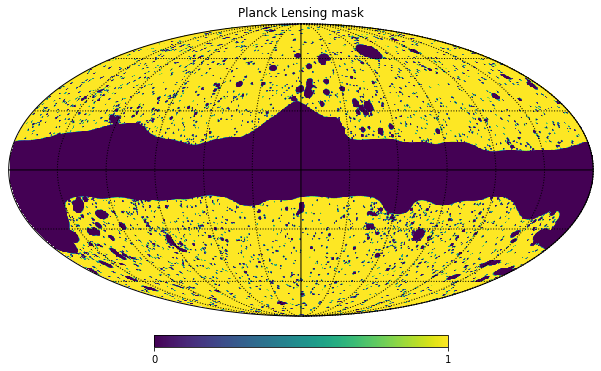

In [10]:
hp.mollview(mask_lensing, title=rf"Planck Lensing mask", unit="",
            cmap='viridis', #coord=['C', 'G']
)
hp.graticule()

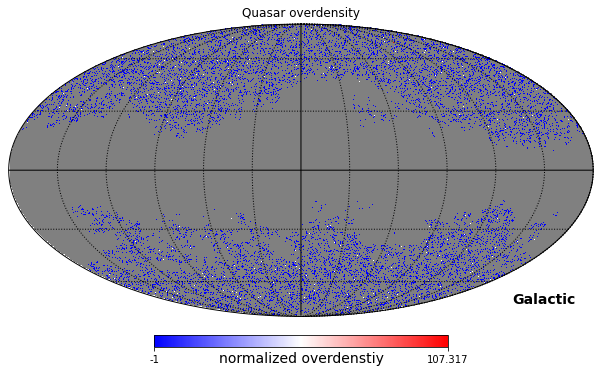

In [11]:
hp.mollview(map_overdensity, title=rf"Quasar overdensity",
    unit=r"normalized overdenstiy", cmap='bwr', coord=['C', 'G'])#, min=-1, max=1)
hp.graticule()

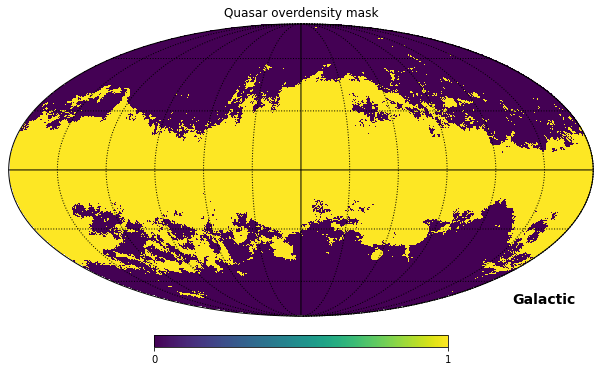

In [12]:
hp.mollview(mask_overdensity, title=rf"Quasar overdensity mask",
    unit=r"", cmap='viridis', coord=['C', 'G'], min=0, max=1)
hp.graticule()

# Load in Cl results

In [13]:
res_Cls = np.load(fn_Cls)
ell_arr, Cls_kk, Cls_kq, Cls_qq = res_Cls

In [14]:
mult_fac = 1e6

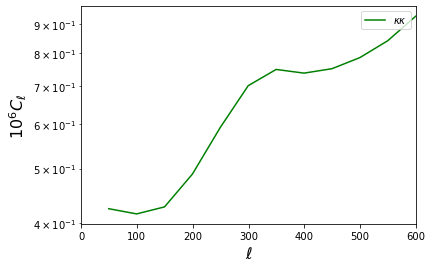

In [15]:
plt.plot(ell_arr, mult_fac*Cls_kk, 'g-', label=r'$\kappa \kappa$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

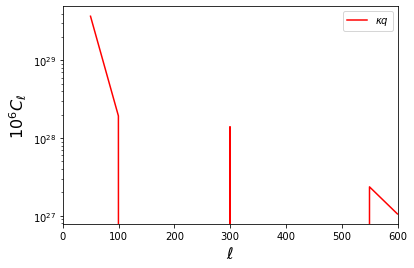

In [16]:
plt.plot(ell_arr, mult_fac*Cls_kq, 'r-', label=r'$\kappa q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

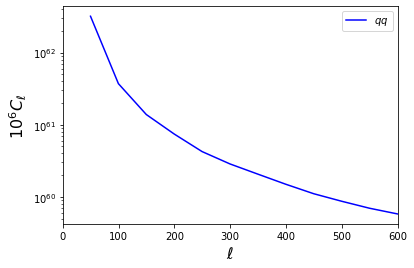

In [17]:
plt.plot(ell_arr, mult_fac*Cls_qq, 'b-', label=r'$q q$')
plt.yscale('log')
plt.xlim(0, 600)
#plt.ylim(1e-1, 1e1)
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$10^6 C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()